In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Загрузка и подготовка данных

In [3]:
# Загрузка данных Iris
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
data = iris[['sepal_length', 'sepal_width', 'petal_width', 'species']]

# Фильтрация данных только для двух видов ирисов
data_df = data[(data['species'] == 'setosa') | (data['species'] == 'versicolor')]

# Разделение на признаки и целевую переменную
X = data_df[['sepal_length', 'sepal_width', 'petal_width']]
y = data_df['species']

print(f"Размерность данных: {X.shape}")
print(f"Классы: {y.unique()}")
print(f"Количество образцов: {len(data_df)}")

Размерность данных: (100, 3)
Классы: ['setosa' 'versicolor']
Количество образцов: 100


Визуализация исходных данных в 3D

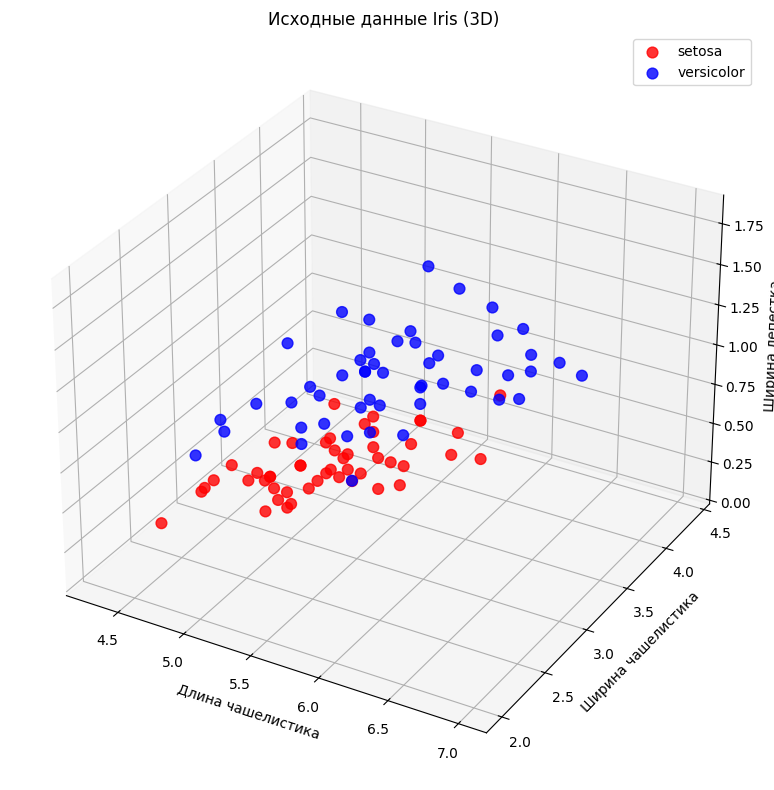

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Разделение данных по видам для визуализации
setosa_data = data_df[data_df['species'] == 'setosa']
versicolor_data = data_df[data_df['species'] == 'versicolor']

# Визуализация точек данных
ax.scatter(setosa_data['sepal_length'], setosa_data['sepal_width'], setosa_data['petal_width'],
          c='red', label='setosa', s=60, alpha=0.8)
ax.scatter(versicolor_data['sepal_length'], versicolor_data['sepal_width'], versicolor_data['petal_width'],
          c='blue', label='versicolor', s=60, alpha=0.8)

ax.set_xlabel('Длина чашелистика')
ax.set_ylabel('Ширина чашелистика')
ax.set_zlabel('Ширина лепестка')
ax.set_title('Исходные данные Iris (3D)')
ax.legend()
plt.tight_layout()
plt.show()

Обучение SVM модели

In [5]:
# Создание и обучение SVM модели с линейным ядром
model = SVC(kernel='linear')
model.fit(X, y)

# Получение весов и смещения модели
w = model.coef_[0]
b = model.intercept_[0]

print(f"Веса модели: {w}")
print(f"Смещение: {b:.4f}")
print(f"Количество опорных векторов: {len(model.support_vectors_)}")

Веса модели: [ 0.59440043 -1.08971638  1.73177413]
Смещение: -1.1972
Количество опорных векторов: 7


Визуализация разделяющей гиперплоскости

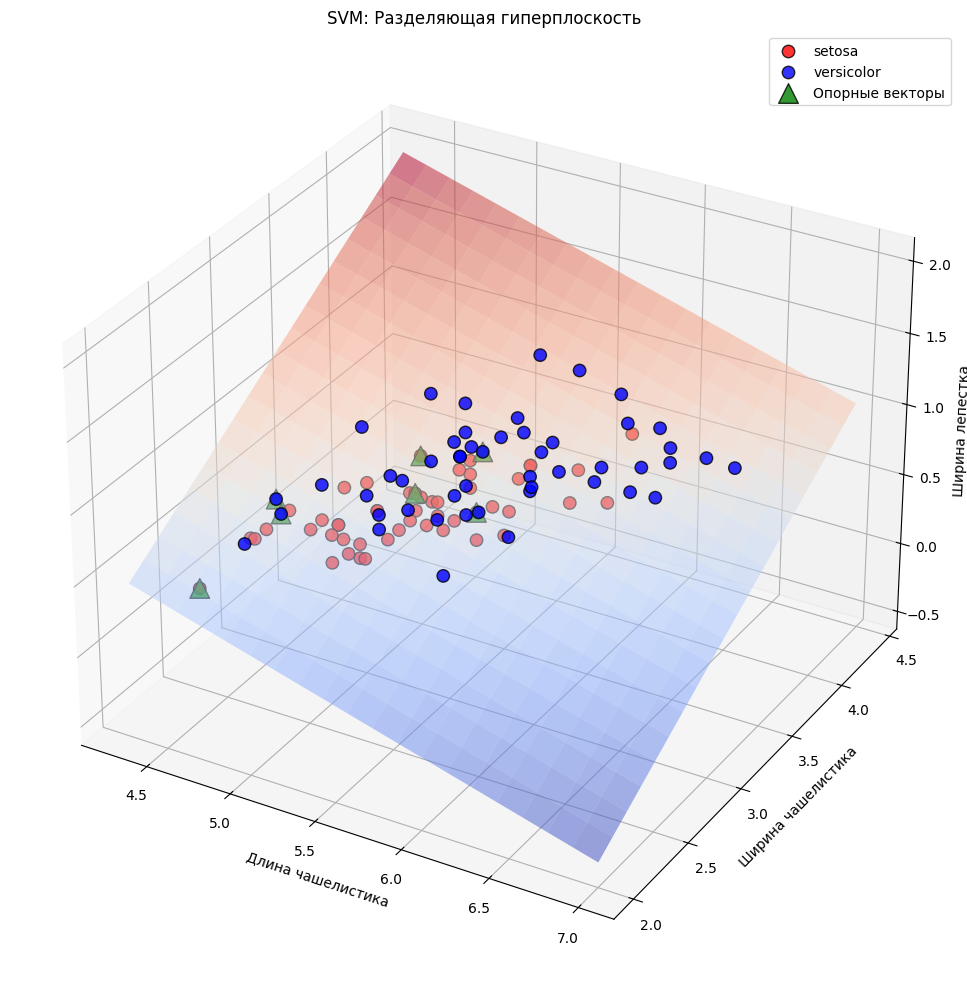

In [7]:
# Создание сетки для построения разделяющей гиперплоскости
x_min, x_max = X['sepal_length'].min(), X['sepal_length'].max()
y_min, y_max = X['sepal_width'].min(), X['sepal_width'].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))

# Вычисление z-координаты для гиперплоскости
zz = (-w[0] * xx - w[1] * yy - b) / w[2]

# Создание 3D визуализации
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Отображение гиперплоскости
ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='coolwarm')

# Отображение точек данных
ax.scatter(setosa_data['sepal_length'], setosa_data['sepal_width'], setosa_data['petal_width'],
          c='red', label='setosa', s=80, alpha=0.8, edgecolors='black')
ax.scatter(versicolor_data['sepal_length'], versicolor_data['sepal_width'], versicolor_data['petal_width'],
          c='blue', label='versicolor', s=80, alpha=0.8, edgecolors='black')

# Отображение опорных векторов
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], model.support_vectors_[:, 2],
          c='green', marker='^', s=200, label='Опорные векторы', alpha=0.8, edgecolors='black')

ax.set_xlabel('Длина чашелистика')
ax.set_ylabel('Ширина чашелистика')
ax.set_zlabel('Ширина лепестка')
ax.set_title('SVM: Разделяющая гиперплоскость')
ax.legend()
plt.tight_layout()
plt.show()


Применение PCA для снижения размерности

Объясненная дисперсия: [0.73201557 0.22855137]
Суммарная объясненная дисперсия: 0.961


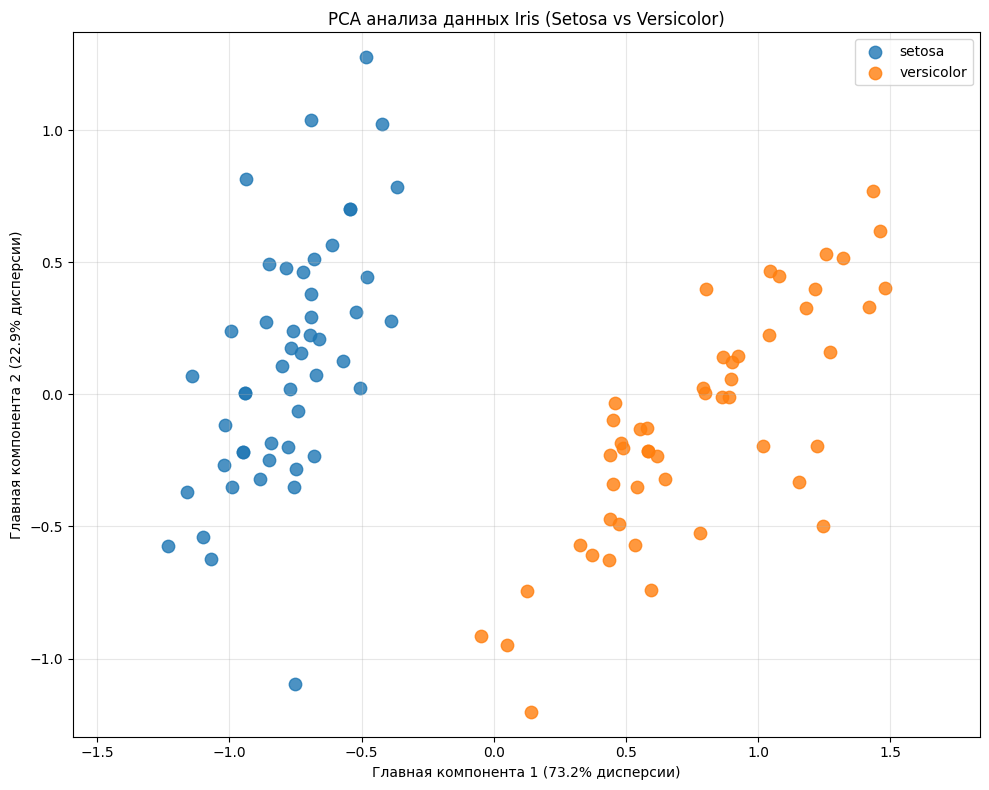

In [9]:
# Применение PCA для снижения размерности до 2 компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Создание DataFrame с главными компонентами
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['species'] = y.reset_index(drop=True)

print(f"Объясненная дисперсия: {pca.explained_variance_ratio_}")
print(f"Суммарная объясненная дисперсия: {sum(pca.explained_variance_ratio_):.3f}")

# Визуализация PCA результатов
plt.figure(figsize=(10, 8))
for species in ['setosa', 'versicolor']:
    species_data = pca_df[pca_df['species'] == species]
    plt.scatter(species_data['PC1'], species_data['PC2'], label=species, s=80, alpha=0.8)

plt.xlabel('Главная компонента 1 ({:.1f}% дисперсии)'.format(pca.explained_variance_ratio_[0]*100))
plt.ylabel('Главная компонента 2 ({:.1f}% дисперсии)'.format(pca.explained_variance_ratio_[1]*100))
plt.title('PCA анализа данных Iris (Setosa vs Versicolor)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()


Кластеризация методом K-means

Центры кластеров:
[[5.006 3.428 0.246]
 [5.936 2.77  1.326]]
Инерция: 33.47


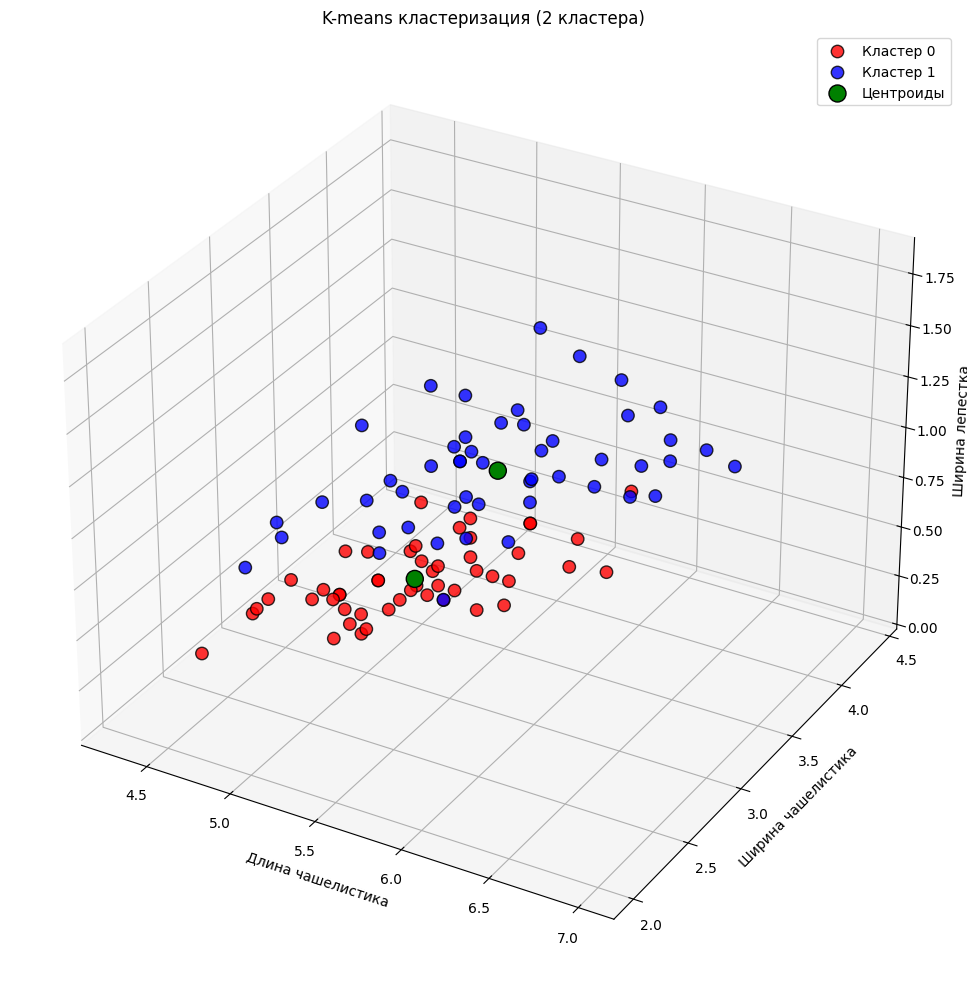

In [14]:
# Создание копии данных для кластеризации
X_cluster = X.copy()

# Создание и обучение K-means модели с 2 кластерами
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_cluster)

# Добавление меток кластеров к данным
X_cluster['cluster'] = kmeans.labels_.astype(str)

print(f"Центры кластеров:\n{kmeans.cluster_centers_}")
print(f"Инерция: {kmeans.inertia_:.2f}")

# Визуализация результатов кластеризации в 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Цвета для кластеров
colors = ['red', 'blue']
cluster_labels = ['Кластер 0', 'Кластер 1']

for i, cluster in enumerate(['0', '1']):
    cluster_data = X_cluster[X_cluster['cluster'] == cluster]
    ax.scatter(cluster_data['sepal_length'], cluster_data['sepal_width'], cluster_data['petal_width'],
              c=colors[i], label=cluster_labels[i], s=80, alpha=0.8, edgecolors='black')

# Отображение центроидов кластеров
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
          c='green', marker='o', s=150, label='Центроиды', alpha=1.0, edgecolors='black')

ax.set_xlabel('Длина чашелистика')
ax.set_ylabel('Ширина чашелистика')
ax.set_zlabel('Ширина лепестка')
ax.set_title('K-means кластеризация (2 кластера)')
ax.legend()
plt.tight_layout()
plt.show()